In [1]:
import numpy as np
import pandas as pd
import tqdm
from scipy.optimize import minimize, least_squares, differential_evolution, dual_annealing,basinhopping 
import matplotlib.pyplot as plt
from matplotlib import rc

In [2]:
Max_epochs=1000
Epsilon=1e-3

In [3]:
#generate the noisy data
X = np.arange(0, 3.003, 0.003)
def generator(X):
    f_x = 1/((X ** 2) - (3 * X) + 2)
    f_x = np.clip(f_x, -100, 100)
    noise = np.random.normal(size=X.shape)
    return f_x, f_x + noise
y_k, y = generator(X)
data = pd.DataFrame({'X': X, 'y_k': y_k, 'y': y})

In [4]:
data

,X,y_k,y
0,0.000,0.500000,-0.594474
1,0.003,0.502258,0.290986
2,0.006,0.504532,-0.773406
3,0.009,0.506822,0.764767
4,0.012,0.509128,1.090343
...,...,...,...
996,2.988,0.509128,0.517494
997,2.991,0.506822,-1.302592
998,2.994,0.504532,-0.453362
999,2.997,0.502258,0.961011


In [5]:
def function(X, params):
    params = np.asarray(params)
    if params.ndim == 1:
        return np.clip((params[0] * X + params[1]) / (X ** 2 + params[2] * X + params[3]), -100, 100)
    if params.ndim == 2:
        return np.clip(
            (params[:, 0] * X[:, None] + params[:, 1]) / (X[:, None] ** 2 + params[:, 2] * X[:, None] + params[:, 3]),
            -100,
            100,
        )

In [6]:
def loss(func, X, params, y_k, reduction=True):
    y = func(X, params)
    if params.ndim == 1:
        if reduction:
            return np.sum((y - y_k) ** 2)
        else:
            return y - y_k
    if params.ndim == 2:
        return np.sum((y - y_k[:, None]) ** 2, axis=0)

In [7]:
def nelder_mead(X, y_k, params_init, epsilon=Epsilon, max_epochs=Max_epochs):
    def func(x):
        return loss(eval('function'), X=X, params=x, y_k=y_k)

    result = minimize(
        func,
        x0=params_init,
        method='nelder-mead',
        options={'maxiter': max_epochs, 'maxfev': max_epochs, 'xatol': epsilon, 'fatol': epsilon},
    )
    return {'args': result.x, 'iterations': result.nit, 'function evaluations': result.nfev}

In [8]:
def lm(X, y_k, params_init, epsilon=Epsilon, max_epochs=Max_epochs):
    def func(x):
        return loss(eval('function'), X, params=x, y_k=y_k, reduction=False)

    def grad(x):
        nom = x[0] * X + x[1]
        denom = X ** 2 + x[2] * X + x[3]
        zero_grad = ((nom / denom) > 100) & ((nom / denom) < 100)
        grad_ = []
        grad_.append(X / denom)
        grad_.append(1 / denom)
        grad_.append(-nom * X / (denom ** 2))
        grad_.append(-nom / (denom ** 2))
        grad_ = np.asarray(grad_).T
        grad_[zero_grad] = 0
        return grad_

    result = least_squares(
        func, x0=params_init, jac=grad, method='lm', ftol=epsilon, gtol=epsilon, max_nfev=max_epochs
    )
    return {'args': result.x, 'iterations': result.nfev+result.njev, 'function evaluations': result.nfev + result.njev}

In [9]:
def diff_evolution(X, y_k, params_init, epsilon=Epsilon, max_epochs=Max_epochs):
    def func(x):
        return loss(eval('function'), X=X, params=x, y_k=y_k)
    
    bounds = list(zip([-3] * 4, [3] * 4))
    init_pop = np.vstack([np.random.uniform(-4, 4, (7, 4)), params_init.reshape(1, -1)])

    result = differential_evolution(
        func, bounds=bounds, maxiter=max_epochs, init=init_pop, atol=epsilon, seed=554
    )
    return {'args': result.x, 'iterations': result.nit, 'function evaluations': result.nfev}

In [10]:
def simulated_annealing(X, y_k, params_init, epsilon=Epsilon, max_epochs=Max_epochs):
    def func(x):
        return loss(eval('function'), X=X, params=x, y_k=y_k)
    
    bounds = list(zip([-3] * 4, [3] * 4))

    result = dual_annealing(
        func, bounds=bounds, maxiter=max_epochs,seed=554
    )
    return {'args': result.x, 'iterations': result.nit, 'function evaluations': result.nfev}

In [11]:
init_params = np.asarray([0, 1, -3, 1])
data_opt = []
for method in tqdm.tqdm(['nelder_mead', 'lm', 'diff_evolution','simulated_annealing' ]):
    opt_res = eval(method)(data["X"], data["y"], init_params, Max_epochs)
    data_opt.append(
        {
            'method': method,
            'params': opt_res['args'].tolist(),
            'iterations': opt_res['iterations'],
            'function evaluations': opt_res['function evaluations']
        }
    )

approx = pd.DataFrame(data_opt)

100%|██████████| 4/4 [00:19<00:00,  4.92s/it]


In [12]:
approx

,method,params,iterations,function evaluations
0,nelder_mead,"[0.03027003257126748, 0.994046526283421, -3.00...",27,60
1,lm,"[0.03, 1.0, -3.01, 2.0]",2,2
2,diff_evolution,"[0.001986777751842445, 0.9945018218467174, -3....",78,802
3,simulated_annealing,"[-1.054851884963102, 1.0544549242861276, -1.99...",1000,10091


In [13]:
plt.rcParams['figure.figsize'] = (10, 6)
rc('font', family='serif', serif='Times New Roman')
METHODS = {'nelder_mead': 'Nelder-Mead',
           'lm': 'Levenberg-Marquardt',
           'diff_evolution': 'Differential Evolution',
          'simulated_annealing': 'Simulated annealing'}

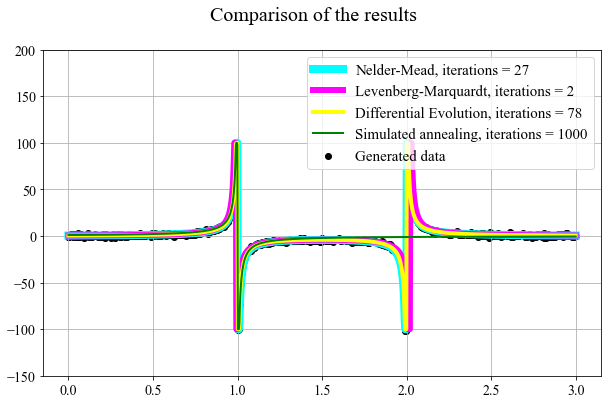

In [14]:
plt.scatter(data['X'], data['y'], c='black', label='Generated data')
plt.grid()
for method, color,linewidth in zip(['nelder_mead', 'lm', 'diff_evolution', 'simulated_annealing'],
                         ['cyan', 'magenta', 'yellow','green'],[8,6,4,2]):
    row = approx[approx['method'] == method]
    iters = row['iterations'].values[0]
    params = row['params'].values[0]
    approx_y = function(data['X'], params)
    plt.plot(data['X'], approx_y, c=color,linewidth=linewidth, label=f'{METHODS[method]}, iterations = {iters}')

plt.ylim([-150, 200])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best',fontsize=15)
plt.suptitle('Сomparison of the results', fontsize=20)
plt.savefig(fname='Сomparison of the results.png', format='png')

